In [1]:
from matplotlib import pyplot as plt

In [2]:
from numpy import array
from numpy.linalg import norm
from math import pi, cos, sin, atan2, copysign
import numpy as np
from time import sleep

#from IK import L0, L12, L23, L34, L45, bodyH
from design_helpers import gen_sides
from IK import ALL_FEET_DOWN_TIME_FRAC, TRANSITION_FRAC, FH_FRAC, FH, Gaits
# L0 is the dynamic length of the leg? from pivot to ground contact?
from intersections import intersectLines

# Numa V1
L0=110; L12=58; L23=63; L34=67; L45=57; bodyH=150

legLen = 1.05*L0

In [3]:
# sides are the leg edge we worry about colliding.
# These are two points as vectors from the base of a leg segment
# Numa V2
side23 = [[24.77, -35.15],[24.77+17.78, -6.17]]
side23 = [[0, -5], [50, -5]]
side34 = [[24.95, -9.01],[24.95+35.81, -16.09]]
side34 = [[0, -5], [40, -5]]
   

Now what am I doing?

In [4]:
def snapshot(gait, ms, loopLength=10000, ang_dir=0.0):
    """Get leg position at a single time within the loop length"""
    
    travRate = 25
    times = []
    points = []

    half_loopLength = loopLength/2.0
    double_travRate = 2 * travRate
    #gait = Gaits()

    # TODO move this
    #ms = 0 #0
    turnTimeOffset = 0 # probalby don't need this for now except as placeholder
    now2 = (ms - turnTimeOffset) % loopLength
    now3 = (ms - turnTimeOffset +  half_loopLength) % loopLength
    now4 = loopLength - (ms - turnTimeOffset) % loopLength
    now1 = loopLength - (ms - turnTimeOffset + half_loopLength) % loopLength

    gait.initTrig()
    gait.walkCode(loopLength, half_loopLength, travRate, 2*travRate,
                  now1, now2, now3, now4, ang_dir)

In [5]:
masses = [115, 60, 20] # masses in grams for segments 23, 34, 45 respectively. 55g per AX12 servo
body_mass = 2000/2 + sum(masses) # 2kg / 2 + a leg
def torque(pts):
    torques = []
    # on the ground
    if abs(pts[-1][1]) > 0.9 * bodyH:
        #pt_servo, pt_gnd = pts[0], pts[-1]
        #torque = pt_gnd[0] - pt_servo[0]
        for pt in pts[2:-2]:
            torques.append(body_mass * (pts[-1][0] - pt[0])) # expect mostly positive
    # off the ground
    else:
        # for each servo point of interest
        for cnt, pt in enumerate(pts[2:-2]):
            # Get the midpoint's distance of each segment multiplied by mass
            # For point  
            torques.append(0)
            for x in range(len(pts[cnt+1:-1])):
                midpt = pts[cnt+x][0] - pts[cnt+x+1][0]
                dist = pt[0] - midpt # expect mostly negative
                mass_dist = dist * 1# masses[cnt]
                torques[-1] += mass_dist
            #for ptb in pts:
            #    pt[0] - ptb
            
    
    #torque = pt_gnd[0] - pt_servo[0]
    #pass
    return torques

In [6]:
def mkpts():# calculate the points I want to plot: aka the servo joints
    pt1 = array([L0, 0])
    pt2 = pt1 + array([L12,0])
    pt3 = pt2 + gait.v23 # we do this negative in the code, too
    pt4 = pt3 + [gait.v34[0], -gait.v34[1]]
    pt5 = pt4 + [0, -L45] #[10,0]#
    pt0 = pt1 - [0, bodyH]

    pts = array([pt0, pt1, pt2, pt3, pt4, pt5])
    
    #sides = []
    #sides.append(array([])
    return pts#, sides

True


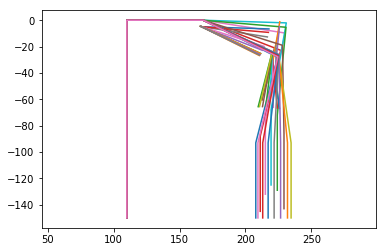

In [7]:
gait = Gaits(L0, L12, L23, L34, L45, bodyH)
plt.figure()
ax1 = plt.subplot(1,1,1)
torques = []
foot_height = []
foot_trav = []
intersections = []
#foot_trav0 = L0
for x in range(0,10000,800):
    snapshot(gait, x, 10000)
    pts  = mkpts()
    xvals, yvals = np.transpose(pts[:])
    ax1.set_aspect('equal', 'datalim')
    ax1.plot(xvals, yvals)
    
    # calc torques and leg heights
    torques.append(torque(pts))
    foot_height.append(yvals[5] + bodyH)
    foot_trav.append(xvals[5] - 2*legLen)
    
    # gen and plot servo sides
    sidepts = gen_sides(pts, sides=[side23,side34])
    for ptset in sidepts[:]:
        xvals, yvals = np.transpose(ptset[:])
        ax1.plot(xvals, yvals)
torques = np.transpose(array(torques[:]))
print(True)

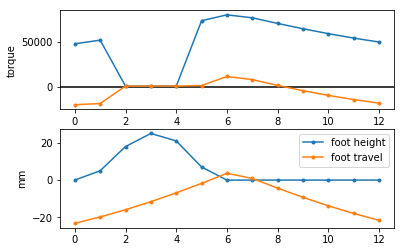

In [8]:
plt.figure()
ax2 = plt.subplot(2,1,1)
ax2.axhline(y=0, color='k')
ax2.set_ylabel("torque")

ax3 = plt.subplot(2,1,2)
ax3.set_ylabel("mm")
#print(torques)

for dataset in torques:#[2]:
    ax2.plot(dataset, marker=".")
ax3.plot(foot_height, label="foot height", marker=".")
ax3.plot(foot_trav, label="foot travel", marker=".")
ax3.legend()

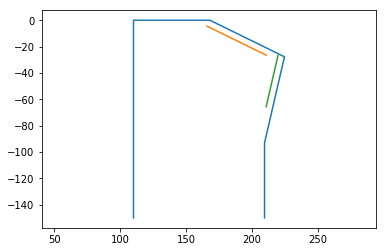

In [9]:
# Looking at a single set of points for debugging
plt.figure()
ax1 = plt.subplot(1,1,1)
#snapshot(gait, x, 10000)
pts  = mkpts()
xvals, yvals = np.transpose(pts[:])
ax1.set_aspect('equal', 'datalim')
ax1.plot(xvals, yvals)

# gen and plot servo sides
sidepts = gen_sides(pts, sides=[side23, side34])
for ptset in sidepts[:]:
    xvals, yvals = np.transpose(ptset[:])
    ax1.plot(xvals, yvals)